In [ ]:
import pandas as pd


data = pd.read_csv('bombay.csv')

In [ ]:
data['Date'] = pd.to_datetime(data['date_time'])

In [ ]:
data.tail()


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,windspeedKmph,tempC,Date
96427,2020-01-01 19:00:00,27,24,0.0,11.0,7,6,37,11:38 AM,11:36 PM,07:12 AM,06:12 PM,18,26,26,25,16,4,64,0.0,1014,10,324,14,25,2020-01-01 19:00:00
96428,2020-01-01 20:00:00,27,24,0.0,11.0,7,1,37,11:38 AM,11:36 PM,07:12 AM,06:12 PM,18,26,26,25,15,4,65,0.0,1015,10,330,13,25,2020-01-01 20:00:00
96429,2020-01-01 21:00:00,27,24,0.0,11.0,7,1,37,11:38 AM,11:36 PM,07:12 AM,06:12 PM,18,26,26,25,14,4,67,0.0,1015,10,335,13,25,2020-01-01 21:00:00
96430,2020-01-01 22:00:00,27,24,0.0,11.0,7,1,37,11:38 AM,11:36 PM,07:12 AM,06:12 PM,18,26,26,25,13,4,66,0.0,1015,10,301,12,25,2020-01-01 22:00:00
96431,2020-01-01 23:00:00,27,24,0.0,11.0,7,1,37,11:38 AM,11:36 PM,07:12 AM,06:12 PM,18,26,26,24,12,4,66,0.0,1015,10,267,10,24,2020-01-01 23:00:00


In [ ]:
data = data.set_index('Date')

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
data_temp = data[['tempC']]

data_temp.loc[:,'Yesterday'] = data_temp.loc[:, 'tempC'].shift(24)


data_temp.loc[:,'Yesterday_Diff'] = -(data_temp.loc[:,'Yesterday'] - data_temp.loc[:,'tempC']).shift(1)

data_temp = data_temp.dropna()


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
data_temp


,tempC,Yesterday,Yesterday_Diff
Date,,,
2009-01-02 01:00:00,23,22.0,2.0
2009-01-02 02:00:00,23,22.0,1.0
2009-01-02 03:00:00,23,22.0,1.0
2009-01-02 04:00:00,23,22.0,1.0
2009-01-02 05:00:00,23,22.0,1.0
...,...,...,...
2020-01-01 19:00:00,25,23.0,1.0
2020-01-01 20:00:00,25,22.0,2.0
2020-01-01 21:00:00,25,21.0,3.0


In [ ]:
X_train = data_temp[:'2018'].drop(['tempC'], axis =1)
y_train = data_temp.loc[:'2018', 'tempC']

X_test = data_temp['2019':].drop(['tempC'], axis =1)
y_test = data_temp.loc['2019':, 'tempC']

LR: 0.961312 (0.009809)
RF: 0.960650 (0.009147)


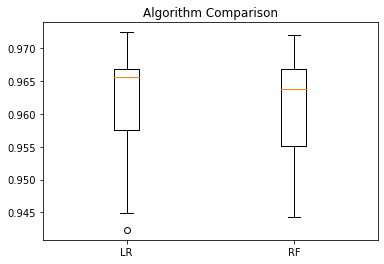

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

models = []
models.append(('LR', LinearRegression()))
#models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
#models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
#models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
best_model = RandomForestRegressor()
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
  predict = np.array(predict)
  actual = np.array(actual)
  distance = predict - actual
  square_distance = distance ** 2
  mean_square_distance = square_distance.mean()
  score = np.sqrt(mean_square_distance)
  return score
rmse_score = make_scorer(rmse, greater_is_better = False) 

In [ ]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
param_search = {
    'n_estimators': [20, 100],
    'max_depth' : [5, 10 ,12]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

explained_variance:  0.7603
mean_squared_log_error:  0.0163
r2:  0.7603
MAE:  0.5291
MSE:  1.4995
RMSE:  1.2245


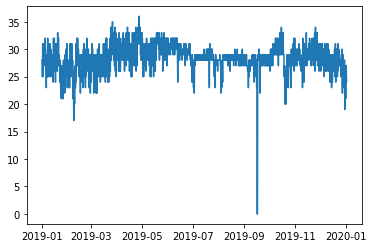

In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

plt.plot(X_test.index, y_true)
plt.show()

In [ ]:
X_test.head()

,Yesterday,Yesterday_Diff
Date,,
2019-01-01 00:00:00,22.0,3.0
2019-01-01 01:00:00,22.0,6.0
2019-01-01 02:00:00,22.0,6.0
2019-01-01 03:00:00,22.0,5.0
2019-01-01 04:00:00,22.0,5.0


In [ ]:
X_train.tail()

,Yesterday,Yesterday_Diff
Date,,
2018-12-31 19:00:00,25.0,-0.0
2018-12-31 20:00:00,24.0,-1.0
2018-12-31 21:00:00,23.0,-0.0
2018-12-31 22:00:00,23.0,-0.0
2018-12-31 23:00:00,23.0,2.0


In [ ]:
best_model.predict([[33, 31.27 -32]])

array([32.15590447])

In [ ]:
import pickle

f = open('weather_model.ser', "wb")
pickle.dump(best_model, f)
f.close()
